# Initialization
- import relevant libraries
- create device and img_size variables

In [5]:
import torch
from torch import device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
ls celebA/model_weights

16_128/  32_128/


In [41]:
import math
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision.transforms import functional as trans_fn
from sklearn.model_selection import train_test_split
import os
import shutil
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
img_size = 128

# Prepare Data
adapted code from Jiang Guan
(only need to run this when data is just downloaded)

In [11]:
prepare_data = 0
if prepare_data == 1:
    # train test split

    # split by id 
    img_id = os.listdir('./celebA/data/img_align_celeba')
    train_id, test_id = train_test_split(img_id, test_size=0.1, random_state=1)      

    # create test and train folder
    train_path = './celebA/data/train'
    os.mkdir(train_path) 
    os.mkdir(train_path + '/original') # save all train data to this path

    test_path = './celebA/data/test'
    os.mkdir(test_path) 
    os.mkdir(test_path + '/original') # save all train data to this path

    for id in train_id: 
    shutil.copy('celebA/data/img_align_celeba/' + id, train_path + '/original')

    for id in test_id: 
        shutil.copy('celebA/data/img_align_celeba/' + id, test_path + '/original')

In [13]:
# downscale images via Pillow 
downscale_imgs = 0
if downscale_imgs == 1:
    downscale_factor_list = [1, 2, 4]
    for path in ['./celebA/data/train/', './celebA/data/test/']:
        img_id_list = os.listdir(path + 'original/')
        for downscale_factor in downscale_factor_list: 
            output_path = path + str(downscale_factor) + 'x'
            os.mkdir(output_path) # save all data to this path
            print(output_path)
            for img_id in tqdm(img_id_list): 
                im = Image.open(path + 'original/' + img_id).convert('RGB')
                im = trans_fn.center_crop(im, img_size)
                newsize = (int(im.width/downscale_factor), int(im.height/downscale_factor))
                # downscale and upscale again
                im = im.resize(newsize) 
                im = im.resize((img_size,img_size))
                im.save(output_path + '/' + img_id + '.png')

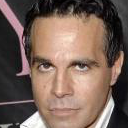

In [12]:
Image.open('./celebA/data/train/1x/000008.jpg.png')

# Dataset and Dataloader
adapted from Jiang Guan


In [46]:
# dataset and dataloader

class CelebDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_dir,
    ):
        self.file_1x_dir = img_dir + '/1x'
        self.file_1x = os.listdir(img_dir + '/1x')
        # self.file_2x = os.listdir(img_dir + '/2x')
        self.file_4x_dir = img_dir + '/4x'
        self.file_4x = os.listdir(img_dir + '/4x')

    def __len__(self):
        return len(self.file_1x) # this is the same for all the files
    
    def __getitem__(self, idx):
        # load the image from disk 
        try:
            img_1x = Image.open(os.path.join(self.file_1x_dir, self.file_1x[idx])).convert('RGB')
            img_4x = Image.open(os.path.join(self.file_4x_dir, self.file_4x[idx])).convert('RGB')

            # apply flip and convert to tensor 
            # flipping
            c = np.random.rand()
            if c > 0.5: 
                img_1x = trans_fn.hflip(img_1x)
                img_4x = trans_fn.hflip(img_4x)

            # to tensor 
            img_1x = ToTensor()(img_1x)
            img_4x = ToTensor()(img_4x)

            return {"1x": img_1x, "4x": img_4x}

        except Exception as exc:
            print("this")
            return None

In [47]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    img_1x = torch.stack([b["1x"] for b in batch]) 
    img_4x = torch.stack([b["4x"] for b in batch])
    return {"HR": img_1x, "SR": img_4x}

In [48]:
# implement custom image_dataset and wrap it with the dataloader
image_datasets = {x: CelebDataset(os.path.join('./celebA/data', x)) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, 
                                              shuffle=True, num_workers=0, collate_fn = collate_fn)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print('size of dataset', dataset_sizes)

size of dataset {'train': 182339, 'test': 20260}


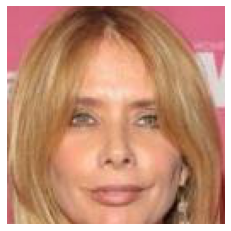

In [52]:
image = image_datasets['test'][10]['1x']
plt.axis("off")
plt.imshow(image.permute(1, 2, 0))
plt.show()

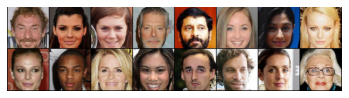

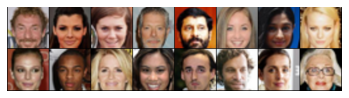

In [53]:
# Get a batch of training data
import cv2
batch = next(iter(dataloaders['train']))
HR = torchvision.utils.make_grid(batch["HR"])
SR = torchvision.utils.make_grid(batch["SR"])
plt.axis("off")
plt.imshow(HR.permute(1, 2, 0))
plt.show()
plt.axis("off")
plt.imshow(SR.permute(1, 2, 0))
plt.show()

# Code for SR3 Model 
Modified https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement/blob/master/model/sr3_modules/diffusion.py (unoffical code for SR3)


Hyperparameters changed for Unet (with reference to config files for sr3):
- changed inner_channel from 64 to 32
- changed channel_mults from [1, 2, 4, 8, 8] to [1, 2, 4, 8]
- changed attn_res from [16] to [8]
- changed res_blocks from 2 to 1
- kept dropout at 0.2
- set image_size at 128

Hyperparameters changed for GaussianDiffusion:
- set timesteps as 500 under set_new_noise_schedule()


Changes made: 
- remove use of base model and model_opt
- adjusted hyperparameters of the model so that it is smaller
- wrote training loop

In [55]:
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        self.set_new_noise_schedule(device)

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, device, schedule="linear", n_timestep=500, linear_start=1e-6, linear_end=0.01):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule,
            n_timestep=n_timestep,
            linear_start=linear_start,
            linear_end=linear_end)
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, continous=False):
        return self.p_sample_loop(x_in, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        # random gama
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['HR']
        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.FloatTensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            )
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(
            b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([x_in['SR'], x_noisy], dim=1), continuous_sqrt_alpha_cumprod)

        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

In [56]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from inspect import isfunction


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6, # should not be changed (takes in LR image as reference and the noise)
        out_channel=3, # should not be changed (should output an image)
        inner_channel=32,
        norm_groups=8,
        channel_mults=[1, 2, 4, 8],
        attn_res=[8],
        res_blocks=1,
        dropout=0.2,
        with_noise_level_emb=True,
        image_size=img_size
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

In [57]:
model = UNet()

In [58]:
def get_model_info(model):
    # Compute number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Compute the size of the model in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    return num_params, size_all_mb

In [59]:
netG = GaussianDiffusion(model,img_size,device).to(device)
netG.set_loss(device)

In [60]:
# Print model info
num_params, size_all_mb = get_model_info(netG)

print("Number of trainable params:", num_params)
print('Model size: {:.3f}MB'.format(size_all_mb))

Number of trainable params: 9736547
Model size: 37.165MB


In [61]:
optG = torch.optim.Adam(netG.parameters(), lr=1e-4)

1x image


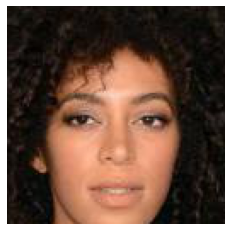

4x image


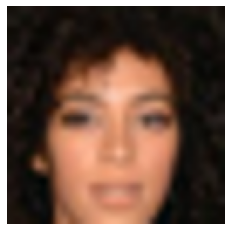

resulting image


sampling loop time step: 100%|██████████| 500/500 [00:08<00:00, 59.16it/s]


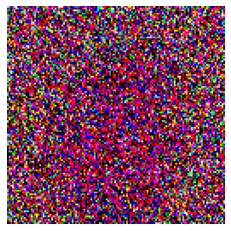

In [62]:
# visualize image
visualize_image = image_datasets['train'][5]

print("1x image")
plt.axis("off")
plt.imshow(visualize_image['1x'].permute(1, 2, 0))
plt.show()

print("4x image")
plt.axis("off")
plt.imshow(visualize_image['4x'].permute(1, 2, 0))
plt.show()

print("resulting image")
plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['4x'][None,:].to(device)).permute(1, 2, 0).cpu())
plt.show()

# Training loop

Wrote training loop and added visualization in training process

In [63]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])     

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [65]:
def train_model(netG, optG, start_epoch=0, end_epoch=10):

    for epoch in range(start_epoch, end_epoch):
        print(f'Epoch {epoch}/{end_epoch - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                netG.train()  # Set model to training mode
            else:
                netG.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch in tqdm(dataloaders[phase]):
                HR_img = batch["HR"].to(device)
                SR_img = batch["SR"].to(device)

                # zero the parameter gradients
                optG.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    l_pix = netG({"HR": HR_img, "SR": SR_img})

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l_pix.backward()
                        optG.step()

                    # statistics
                    running_loss += l_pix.item()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

        # include visualization at start to see progress
        plt.axis("off")
        plt.imshow(netG.super_resolution(visualize_image['4x'][None,:].to(device)).permute(1, 2, 0).cpu())
        plt.show()

        print()

        checkpoint = {
            "state_dict": netG.state_dict(),
            "optimizer": optG.state_dict(),
        }
        
        save_checkpoint(checkpoint, f'./celebA/model_weights/32_128/epoch{epoch}.pth.tar')
        print()

=> Loading checkpoint
Epoch 23/29
----------


100%|██████████| 11397/11397 [28:06<00:00,  6.76it/s]


train Loss: 2251.4894


100%|██████████| 1267/1267 [01:48<00:00, 11.66it/s]


test Loss: 2308.6676


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.97it/s]


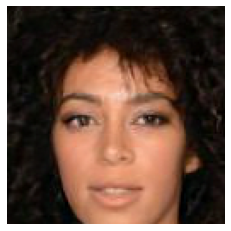


=> Saving checkpoint

Epoch 24/29
----------


100%|██████████| 11397/11397 [27:28<00:00,  6.91it/s]


train Loss: 2258.9463


100%|██████████| 1267/1267 [01:47<00:00, 11.83it/s]


test Loss: 2060.0624


sampling loop time step: 100%|██████████| 500/500 [00:06<00:00, 71.86it/s]


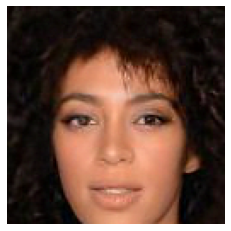


=> Saving checkpoint

Epoch 25/29
----------


100%|██████████| 11397/11397 [27:19<00:00,  6.95it/s]


train Loss: 2252.7182


100%|██████████| 1267/1267 [01:48<00:00, 11.67it/s]


test Loss: 2062.5590


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.90it/s]


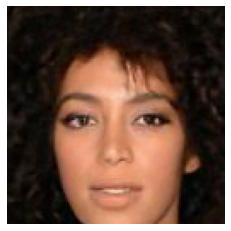


=> Saving checkpoint

Epoch 26/29
----------


  1%|          | 101/11397 [00:14<27:35,  6.82it/s]


KeyboardInterrupt: ignored

In [ ]:
# load checkpoint then train
load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch25.pth.tar"), netG, optG)
train_model(netG, optG, start_epoch=26, end_epoch=40)

# Load saved model

1x image


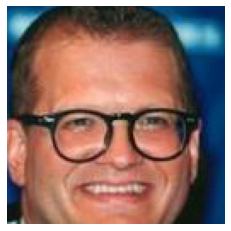

4x image


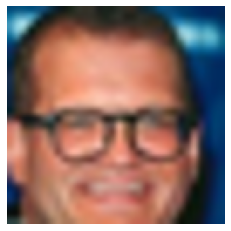

=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.68it/s]


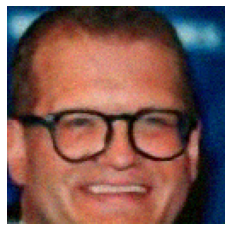

=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.75it/s]


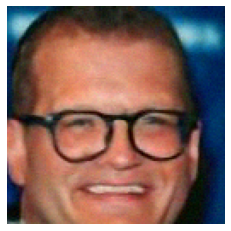

In [66]:
visualize_image = image_datasets['test'][12345]

print("1x image")
plt.axis("off")
plt.imshow(visualize_image['1x'].permute(1, 2, 0))
plt.show()

print("4x image")
plt.axis("off")
plt.imshow(visualize_image['4x'].permute(1, 2, 0))
plt.show()

load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch20.pth.tar"), netG, optG)

plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['4x'][None,:].to(device)).permute(1, 2, 0).cpu())
plt.show()

load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch25.pth.tar"), netG, optG)

plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['4x'][None,:].to(device)).permute(1, 2, 0).cpu())
plt.show()

# Performance evaluation on testing dataset
modified from Xinwen's code

In [106]:
!pip install torchmetrics
!pip install lpips
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
import lpips
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
loss_fn = lpips.LPIPS(net='alex').to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [107]:
def image_convert(image):
    image = image.clone().permute(1, 2, 0).cpu().numpy()
    image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return image

In [93]:
# Evaluate model performance on test dataset
def test_eval(test_data, model):
    l1_loss = []
    mse_loss = []
    psnr_list = []
    ssim_list = []
    output_list = []
    lpips_list = []
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()

    model.eval()
    with torch.no_grad():
        for i in range(0,100,10):
            images = test_data[i]
            input = images['4x']
            target = images['1x']
            input = input.to(device)
            target = target.to(device)
            output = netG.super_resolution(input[None,:])
            output_list.append(output.clone().cpu().detach().numpy())

            # Compute L1 loss
            loss = criterion1(output,target)
            l1_loss.append(loss.item())

            # Compute MSE loss
            loss2 = criterion2(output,target)
            mse_loss.append(loss2.item())

            # Compute PSNR 
            psnr_value = psnr(output.to(device), target)
            psnr_value = psnr_value.clone().cpu().detach().numpy()
            psnr_list.append(psnr_value)
            
            # Compute SSIM
            ssim_value = ssim(output.unsqueeze(0), target.unsqueeze(0))
            ssim_value = ssim_value.clone().cpu().detach().numpy()
            ssim_list.append(ssim_value)

            # Compute LPIPS
            d = loss_fn.forward(output,target).clone().cpu().detach().numpy()
            lpips_list.append(d)

            # Display the LR image, output image and HR image.
            plt.figure(i)
            fig, axs = plt.subplots(1, 3, figsize=(15, 10))
            axs[0].imshow(image_convert(input))
            axs[0].set_title('LR image')
            axs[1].imshow(image_convert(output))
            axs[1].set_title('Output image')
            axs[2].imshow(image_convert(target))
            axs[2].set_title('HR image (Ground Truth)')
            plt.savefig("celebA/results/test_image{}.pdf".format(i), format = "pdf", bbox_inches = "tight")
            plt.show()
    return l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list

=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.32it/s]


<Figure size 432x288 with 0 Axes>

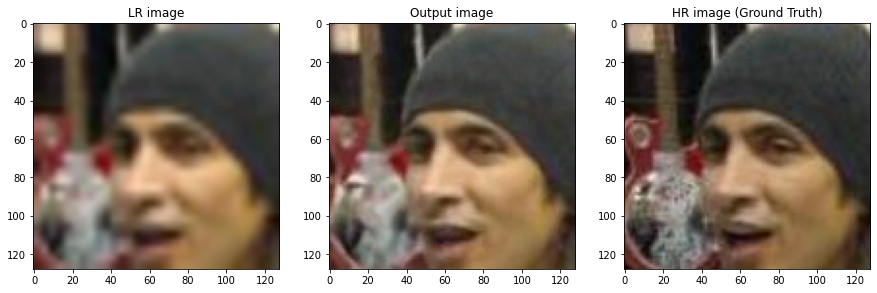

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.25it/s]


<Figure size 432x288 with 0 Axes>

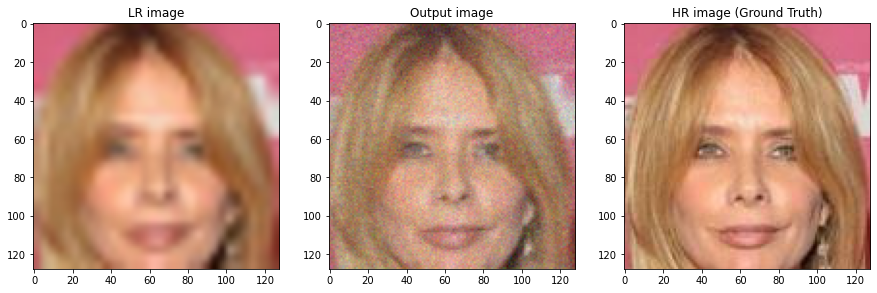

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.55it/s]


<Figure size 432x288 with 0 Axes>

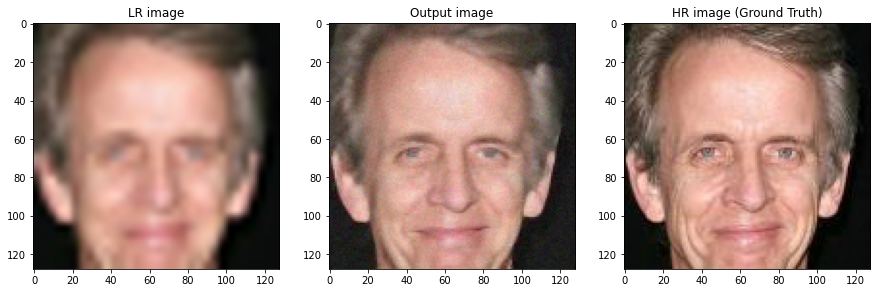

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.93it/s]


<Figure size 432x288 with 0 Axes>

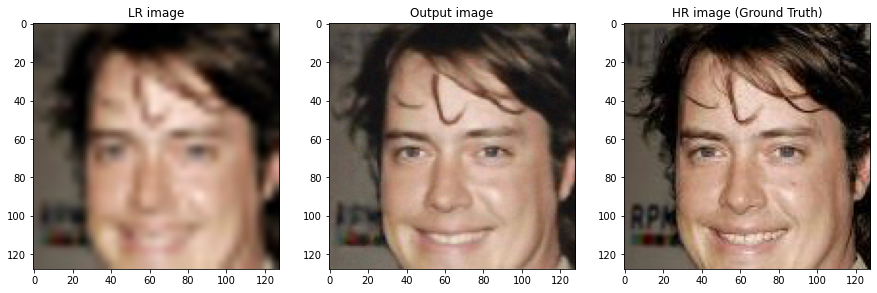

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.32it/s]


<Figure size 432x288 with 0 Axes>

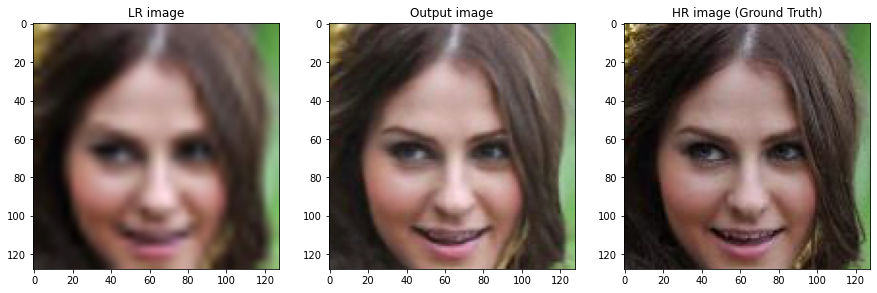

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.08it/s]


<Figure size 432x288 with 0 Axes>

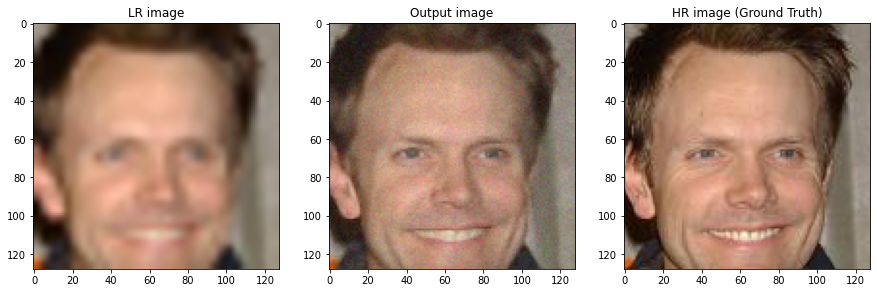

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.35it/s]


<Figure size 432x288 with 0 Axes>

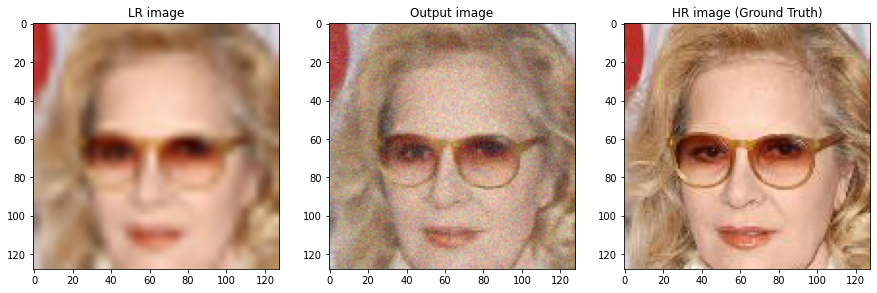

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.89it/s]


<Figure size 432x288 with 0 Axes>

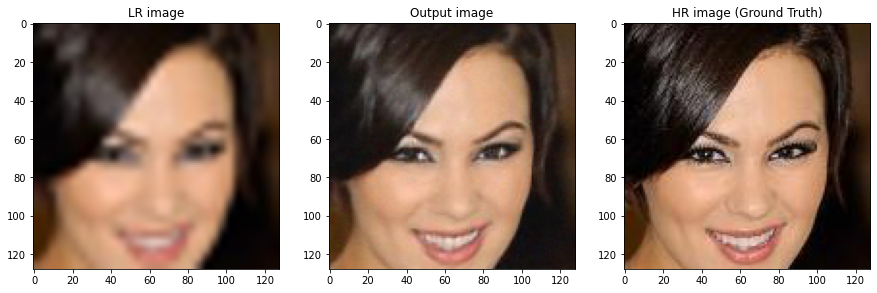

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.77it/s]


<Figure size 432x288 with 0 Axes>

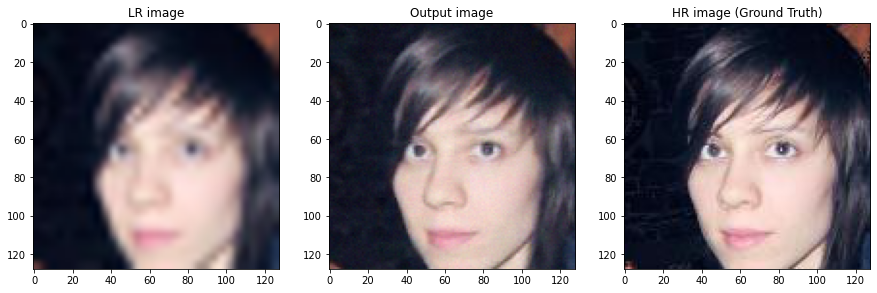

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 68.06it/s]


<Figure size 432x288 with 0 Axes>

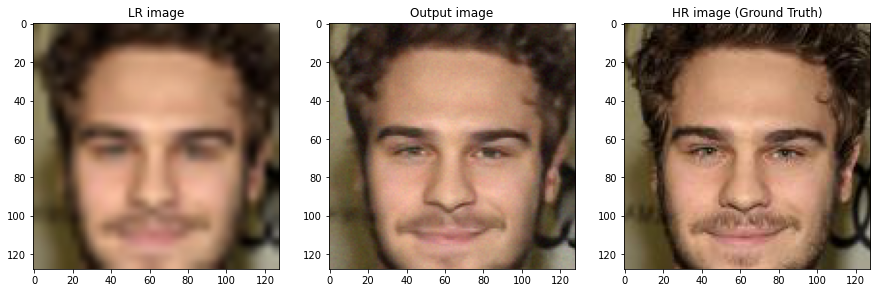

In [94]:
load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch25.pth.tar"), netG, optG)

l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list = test_eval(image_datasets['test'], netG)

In [95]:
!zip -r celebA_results_diffusion_epoch35.zip celebA/results

  adding: celebA/results/ (stored 0%)
  adding: celebA/results/test_image90.pdf (deflated 2%)
  adding: celebA/results/test_image9.pdf (deflated 1%)
  adding: celebA/results/test_image8.pdf (deflated 2%)
  adding: celebA/results/test_image26.pdf (deflated 2%)
  adding: celebA/results/test_image70.pdf (deflated 2%)
  adding: celebA/results/test_image11.pdf (deflated 2%)
  adding: celebA/results/test_image21.pdf (deflated 2%)
  adding: celebA/results/test_image30.pdf (deflated 2%)
  adding: celebA/results/test_image13.pdf (deflated 2%)
  adding: celebA/results/test_image2.pdf (deflated 2%)
  adding: celebA/results/test_image17.pdf (deflated 2%)
  adding: celebA/results/test_image18.pdf (deflated 2%)
  adding: celebA/results/test_image14.pdf (deflated 2%)
  adding: celebA/results/test_image4.pdf (deflated 2%)
  adding: celebA/results/test_image19.pdf (deflated 2%)
  adding: celebA/results/test_image20.pdf (deflated 2%)
  adding: celebA/results/test_image25.pdf (deflated 2%)
  adding: cele

In [96]:
print(np.mean(l1_loss))
print(np.mean(mse_loss))
print(np.mean(psnr_list))
print(np.mean(lpips_list))
print(np.mean(ssim_list))

0.0493650671094656
0.004701322875916958
24.936726
0.094224244
0.70763254


In [ ]:
import torch
torch.cuda.empty_cache()

In [113]:
# Evaluate model performance on test dataset
def base_eval(test_data):
    l1_loss = []
    mse_loss = []
    psnr_list = []
    ssim_list = []
    output_list = []
    lpips_list = []
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()

    for i in range(0,100,10):
        images = test_data[i]
        input = images['4x'].to(device)
        target = images['1x'].to(device)
   
        # Compute L1 loss
        loss = criterion1(input,target)
        l1_loss.append(loss.item())

        # Compute MSE loss
        loss2 = criterion2(input,target)
        mse_loss.append(loss2.item())

        # Compute PSNR 
        psnr_value = psnr(input, target)
        psnr_value = psnr_value.clone().cpu().detach().numpy()
        psnr_list.append(psnr_value)
        
        # Compute SSIM
        ssim_value = ssim(input.unsqueeze(0), target.unsqueeze(0))
        ssim_value = ssim_value.clone().cpu().detach().numpy()
        ssim_list.append(ssim_value)

        # Compute LPIPS
        d = loss_fn.forward(input,target).clone().cpu().detach().numpy()
        lpips_list.append(d)

    return l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list

In [114]:
load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch25.pth.tar"), netG, optG)
l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list = base_eval(image_datasets['test'])

=> Loading checkpoint


In [117]:
print(np.mean(l1_loss))
print(np.mean(mse_loss))
print(np.mean(psnr_list))
print(np.mean(lpips_list))
print(np.mean(ssim_list))

0.029368386790156364
0.0021827041753567757
26.775488
0.35380095
0.7635006


#Test on smaller dataset
(for debugging purposes to make sure that the model runs and trains correctly)

size of dataset {'train': 1000, 'test': 320}
Epoch 0/2
----------


100%|██████████| 63/63 [00:08<00:00,  7.87it/s]


train Loss: 1887.8521


100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


test Loss: 1505.6300


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.71it/s]


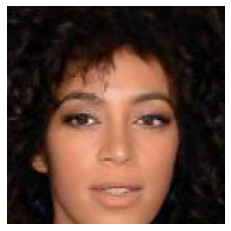


=> Saving checkpoint

Epoch 1/2
----------


100%|██████████| 63/63 [00:08<00:00,  7.86it/s]


train Loss: 2305.7255


100%|██████████| 20/20 [00:01<00:00, 14.39it/s]


test Loss: 3625.1439


sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 69.95it/s]


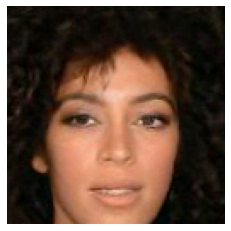


=> Saving checkpoint

Epoch 2/2
----------


 87%|████████▋ | 55/63 [00:07<00:01,  7.71it/s]


KeyboardInterrupt: ignored

In [ ]:
#test on smaller dataloader first

train_subset = torch.utils.data.Subset(image_datasets['train'], range(1000))
eval_subset = torch.utils.data.Subset(image_datasets['test'], range(320))

small_dataloaders = {'train': torch.utils.data.DataLoader(train_subset, batch_size=16, 
                                              shuffle=True, num_workers=0, collate_fn = collate_fn),
                     'test': torch.utils.data.DataLoader(eval_subset, batch_size=16, 
                                              shuffle=True, num_workers=0, collate_fn = collate_fn)}
small_dataset_sizes = {'train': len(train_subset), 'test': len(eval_subset)}
print('size of dataset', small_dataset_sizes)


def small_train_model(netG, optG, start_epoch=0, end_epoch=3):

    for epoch in range(start_epoch, end_epoch):
        print(f'Epoch {epoch}/{end_epoch - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                netG.train()  # Set model to training mode
            else:
                netG.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch in tqdm(small_dataloaders[phase]):
                HR_img = batch["HR"].to(device)
                SR_img = batch["SR"].to(device)

                # zero the parameter gradients
                optG.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    l_pix = netG({"HR": HR_img, "SR": SR_img})

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l_pix.backward()
                        optG.step()

                    # statistics
                    running_loss += l_pix.item()

            epoch_loss = running_loss / small_dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

        # include visualization at start to see progress
        plt.axis("off")
        plt.imshow(netG.super_resolution(visualize_image['4x'][None,:].to(device)).permute(1, 2, 0).cpu())
        plt.show()

        print()

        checkpoint = {
            "state_dict": netG.state_dict(),
            "optimizer": optG.state_dict(),
        }
        save_checkpoint(checkpoint, f'./celebA/model_weights//32_128/test_epoch{epoch}.pth.tar')
        print()

small_train_model(netG, optG, start_epoch=0, end_epoch=3)